In [1]:


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import sys
sys.path.append("../")
import random
from aif360.algorithms.inprocessing.gerryfair_classifier import *
from aif360.algorithms.inprocessing.gerryfair.clean import *
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import *
from aif360.algorithms.inprocessing.gerryfair.auditor import *
from sklearn import svm
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from IPython.display import Image
import pickle
import matplotlib.pyplot as plt



We first demonstrate how to instantiate a `Model`, `train` it with respect to rich subgroup fairness, and `predict` the label of a new example. We remark that when we set the `print_flag = True` at each iteration of the algorithm we print the error, fairness violation, and violated group size of most recent model. The error is the classification error of the classifier. At each round the Learner tries to find a classifier that minimizes the classification error plus a weighted sum of the fairness disparities on all the groups that the Auditor has found up until that point. By contrast the Auditor tries to find the group at each round with the greatest rich subgroup disparity with respect to the Learner's model. We define `violated group size` as the size (as a fraction of the dataset size) of this group, and the `fairness violation` as the `violated group size` times the difference in the statistical rate (FP or FN rate) on the group vs. the whole population. 

In the example below we set `max_iterations=5000` which is in-line with time to convergence observed in [the rich subgroup fairness empirical paper](https://arxiv.org/abs/1808.08166), but advise that this can be highly dataset dependent. Our target $\gamma$-disparity is `gamma = .001`, our statistical rate is false positive rate or `FP`, and our weighted regression oracle is linear regression. We observe that the unconstrained (with no fairness constraint) classifier has error $.185$ and $\gamma$-disparity $.022$. After $5000$ iterations we obtain a classifier that $\gamma$-fair, and has error $.230$. We note that we converge to a fair, and almost as accurate classifier after just a hundred iterations.


In [2]:
C = 10
print_flag = True
gamma = .001
max_iterations = 5000

fair_model = Model(C=C, printflag=print_flag, gamma=gamma, fairness_def='FP',
             max_iters=max_iterations, heatmapflag=False)
data_set = load_preproc_data_adult(sub_samp=200, balance=True)

# fit method
communities_all_errors, communities_violations = fair_model.fit(data_set,
                                                 early_termination=True, return_values=True)

# predict method. If threshold in (0, 1) produces binary predictions

dataset_yhat = fair_model.predict(data_set, threshold=False)




iteration: 1, error: 0.25, fairness violation: 0.029000000000000005, violated group size: 0.2
iteration: 2, error: 0.295, fairness violation: 0.016500000000000004, violated group size: 0.3
iteration: 3, error: 0.31000000000000005, fairness violation: 0.012333333333333335, violated group size: 0.2
iteration: 4, error: 0.3175, fairness violation: 0.010250000000000002, violated group size: 0.2
iteration: 5, error: 0.32199999999999995, fairness violation: 0.009000000000000001, violated group size: 0.2
iteration: 6, error: 0.32499999999999996, fairness violation: 0.008166666666666668, violated group size: 0.2
iteration: 7, error: 0.3271428571428572, fairness violation: 0.007571428571428574, violated group size: 0.2
iteration: 8, error: 0.32875, fairness violation: 0.007124999999999999, violated group size: 0.3
iteration: 9, error: 0.33, fairness violation: 0.00677777777777778, violated group size: 0.2


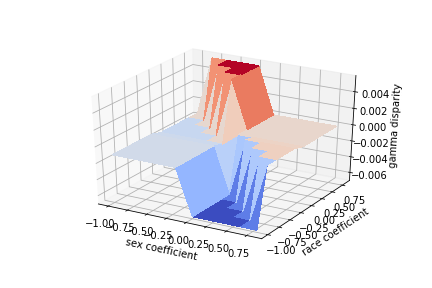

In [3]:

# output heatmap (brute force)
# replace None with the relative path if you want to save the plot
fair_model.heatmapflag = True
fair_model.heatmap_path  = 'heatmap'
fair_model.generate_heatmap(data_set, dataset_yhat.labels)
Image(filename='{}.png'.format(fair_model.heatmap_path)) 





In [4]:
# auditing a classifier for unfairness
# instantiate auditor
auditor = Auditor(data_set, 'FP')
metric_baseline = auditor.get_baseline(array_to_tuple(data_set.labels), array_to_tuple(dataset_yhat.labels))
group = auditor.get_group(dataset_yhat.labels, metric_baseline)
print('gamma disparity: {}'.format(group.weighted_disparity))






gamma disparity: 0.00677777777777778


Curr Predictor: Tree
Curr Predictor: Linear
Curr Predictor: Kernel
Curr Predictor: SVR


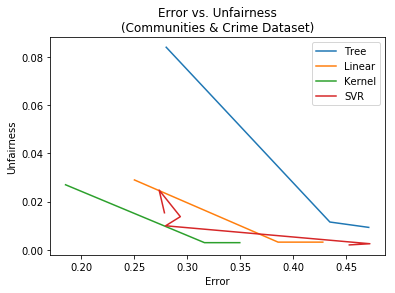

In [5]:
def multiple_classifiers_pareto(dataset, gamma_list=[0.002, 0.005, 0.01, 0.02, 0.05, 0.1], save_results=False, iters=1000):

    ln_predictor = linear_model.LinearRegression()
    svm_predictor = svm.LinearSVR()
    tree_predictor = tree.DecisionTreeRegressor(max_depth=3)
    kernel_predictor = KernelRidge(alpha=1.0, gamma=1.0, kernel='rbf')
    predictor_dict = {'Linear': {'predictor': ln_predictor, 'iters': iters},
                      'SVR': {'predictor': svm_predictor, 'iters': iters},
                      'Tree': {'predictor': tree_predictor, 'iters': iters},
                      'Kernel': {'predictor': kernel_predictor, 'iters': iters}}

    results_dict = {}

    for pred in predictor_dict:
        print('Curr Predictor: {}'.format(pred))
        predictor = predictor_dict[pred]['predictor']
        max_iters = predictor_dict[pred]['iters']
        fair_clf = Model(C=100, printflag=True, gamma=1, predictor=predictor, max_iters=max_iters)
        fair_clf.printflag = False
        fair_clf.set_options(max_iters=max_iters)
        errors, fp_violations, fn_violations = fair_clf.pareto(dataset, gamma_list)
        results_dict[pred] = {'errors': errors, 'fp_violations': fp_violations, 'fn_violations': fn_violations}
        plt.plot(errors, fp_violations, label=pred)

    if save_results:
        pickle.dump(results_dict, open('results_dict_' + str(gamma_list) + '_gammas' + str(gamma_list) + '.pkl', 'wb'))

    plt.xlabel('Error')
    plt.ylabel('Unfairness')
    plt.legend()
    plt.title('Error vs. Unfairness\n(Communities & Crime Dataset)')
    plt.show()

multiple_classifiers_pareto(data_set)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029000000000000005, 0.029000000000000005], [0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.0096, 0.022400000000000003, 0.041600000000000005, 0.041600000000000005])


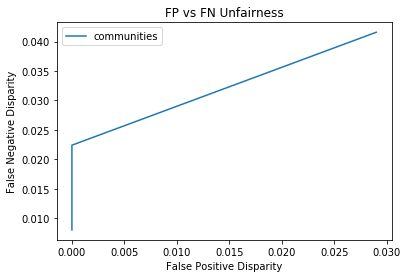

In [6]:

def fp_vs_fn(dataset, gamma_list, iters):
    fp_auditor = Auditor(dataset, 'FP')
    fn_auditor = Auditor(dataset, 'FN')
    fp_violations = []
    fn_violations = []
    for g in gamma_list:
        fair_model = Model(C=100, printflag=False, gamma=g, max_iters=iters)
        fair_model.set_options(gamma=g)
        fair_model.fit(dataset)
        predictions = (fair_model.predict(dataset)).labels
        predictions_inv = tuple([1 - p for p in predictions])
        _, fp_diff = fp_auditor.audit(predictions)
        _, fn_diff = fn_auditor.audit(predictions_inv)
        fp_violations.append(fp_diff)
        fn_violations.append(fn_diff)

    #print((fp_violations, fn_violations))

    plt.plot(fp_violations, fn_violations, label='communities')
    plt.xlabel('False Positive Disparity')
    plt.ylabel('False Negative Disparity')
    plt.legend()
    plt.title('FP vs FN Unfairness')
    plt.show()
    

gamma_list = [0.001, 0.002, 0.003, 0.005, 0.008, 0.01, 0.02]
fp_vs_fn(data_set, gamma_list, 1000)